$But$

Le challenge que nous proposons consiste à reconstruire les données manquantes de certaines courbes de consommation électrique en utilisant uniquement d’autres courbes de consommation électrique.
Nous avons utilisé un outil de génération de courbes synthétiques, DeepCourbogen, pour générer environ 69 000 courbes. 1 000 de ces courbes ont subi des suppressions aléatoires de données, pour simuler les données manquantes de courbes réelles.

Le but des challengers est de proposer des remplacements pour les données manquantes (« remplir les trous ») dans les 1 000 courbes.
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

$Description des données$

Pour l’échantillon d’entrainement :

- la donnée d’entrée est une dataframe de 21 000 colonnes. Chacune d’entre elles est une courbe synthétique générée par DeepCourbogen. Chaque nom de colonne est un identifiant () généré aléatoirement. L’index de la dataframe est le timestamp de chaque point, les valeurs de consommation sont en watts. Les 1 000 dernières colonnes contiennent les courbes auquelles il manque des données. Les noms de ces colonnes sont de la forme holed_
- La donnée de sortie est une dataframe de 1 000 colonnes contenant les données complétées des 1 000 dernières colonnes des données d’entrée.
Le fichier d’entrée fait 140 Mo, le fichier de sortie 6 Mo.

Pour l’échantillon de test, la donnée d’entrée est une dataframe de 38140 colonnes (260 Mo), la donnée de sortie fait toujours 1000 colonnes (6 Mo)
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

X_train = Y_train sauf que dans X_train il y a les données manquantes.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Échantillon d'entraînement
df_X_train = pd.read_csv('X_train_78VdSWL.csv') # Donnée d’entrée, dataframe de 21 000 (140 Mo)
Y_train = pd.read_csv('y_train_u0UkKEh.csv') # Donnée de sortie, 1000 colonnes manquantes (6 Mo)

# Échantillon de test
df_X_test = pd.read_csv('X_test_XKVc4no.csv') # Donnée d’entrée, dataframe de 38140 colonnes (260 Mo)
Y_nouv = pd.read_csv('new_output_sample.csv') # Donnée de sortie, 1000 colonnes manquantes (6 Mo)

In [18]:
df_X_train.columns

Index(['Horodate', '5423908671', '2568793410', '8310762594', '6235194807',
       '423895617', '193845276', '216589743', '218753964', '1794650328',
       ...
       'holed_991', 'holed_992', 'holed_993', 'holed_994', 'holed_995',
       'holed_996', 'holed_997', 'holed_998', 'holed_999', 'holed_1000'],
      dtype='object', length=21001)

On affiche à l'écran le nom de chaque colonne de df_X_train pour pouvoir sélectionner celle que l'on souhaite.

In [19]:
df_X_test['holed_1000'] # NaN est une valeur manquante

0       129.0
1       113.0
2         NaN
3       135.0
4         NaN
        ...  
1052      NaN
1053     78.0
1054     57.0
1055     49.0
1056     42.0
Name: holed_1000, Length: 1057, dtype: float64

On choisi la colonne 'holed_1000 et on observe bien qu'il y a des valeurs manquante

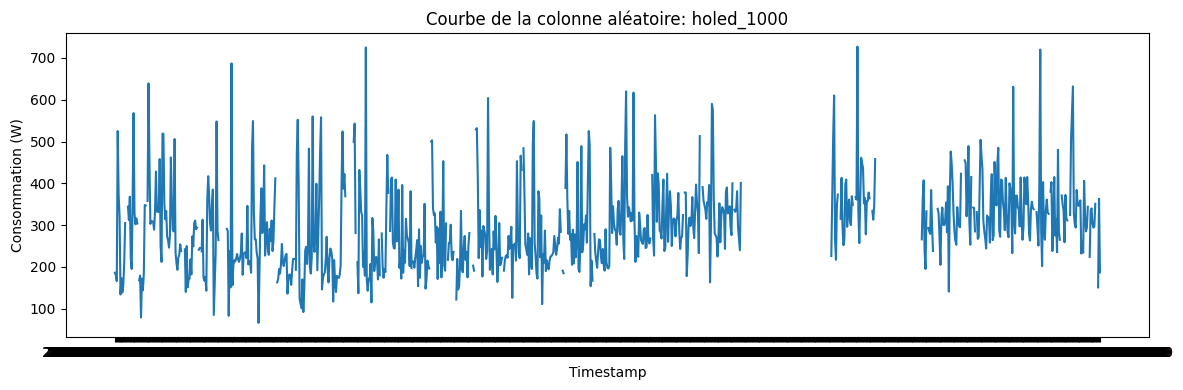

In [20]:
X = df_X_train['Horodate']
Y = df_X_train['holed_1000']
plt.figure(figsize=(12, 4))
plt.plot(X, Y)
plt.title("Courbe de la colonne aléatoire: holed_1000")
plt.xlabel('Timestamp')
plt.ylabel('Consommation (W)')
plt.tight_layout()
plt.show()


#Problème d'affichage des abscisses...

On observe bien sur la courbe qu'il y a des espaces vides, notre but sera de faire des estimations avec le moins d'erreur possibles pour essayer de remplir ses epsaces.